In [12]:
import numpy as np
import torch
import pandas as pd
import torch.nn as nn
import torch.nn.functional as F
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split
from torch.utils.data import DataLoader, TensorDataset

In [13]:
dataFull = pd.read_csv("../FFN/mnist_train_small.csv", header=None)

In [44]:
# normalize the data to a range of [0 1]
dataFull.values[:, 1:] = dataFull.values[:, 1:] / np.max(dataFull.values)

# now for the function
def makeTheDataset(N, doubleTheData = False):

    # extract labels (number ID's) and remove from data
    data = dataFull.values[:N, 1:]
    labels = dataFull.values[:N, 0]  # Convert DataFrame to NumPy before slicing

    # make an exact copy of all the data
    if doubleTheData:
        dataN = data + np.random.random_sample(data.shape)/2 # np.random.random_sample gives a uniform distribution btwn 0 and 1, therfore the entire line gives value btwn 0 and 0.5 
        data = np.concatenate((data, dataN), axis = 0)
        labels = np.concatenate((labels, labels), axis = 0)

    # convert to tensor
    dataT = torch.tensor(data).float()
    labelsT = torch.tensor(labels).long()

    # use scikitlearn to split the data
    train_data, devset_data, train_labels, devset_labels = train_test_split(dataT, labelsT, train_size = .9)

    # make an exact copy of the TRAIN data
    # if doubleTheData:
    #     train_data = torch.cat((train_data, train_data), axis = 0)
    #     train_labels = torch.cat((train_labels, train_labels), axis = 0)
    
    # convert into PyTorch datasets
    train_data = TensorDataset(train_data, train_labels)
    devset_data = TensorDataset(devset_data, devset_labels)

    # translate into dataloader objects
    batchsize = 20
    train_loader = DataLoader(train_data, batch_size = batchsize, shuffle = True, drop_last = True)
    devset_loader = DataLoader(devset_data, batch_size = devset_data.tensors[0].shape[0])

    # create a test set (doesn't need a dataloader)
    testdata = torch.tensor(dataFull.values[N:, 1:]).float()
    testlabels = torch.tensor(dataFull.values[N:, 0]).long()
    
    return train_loader, devset_loader, (testdata, testlabels)

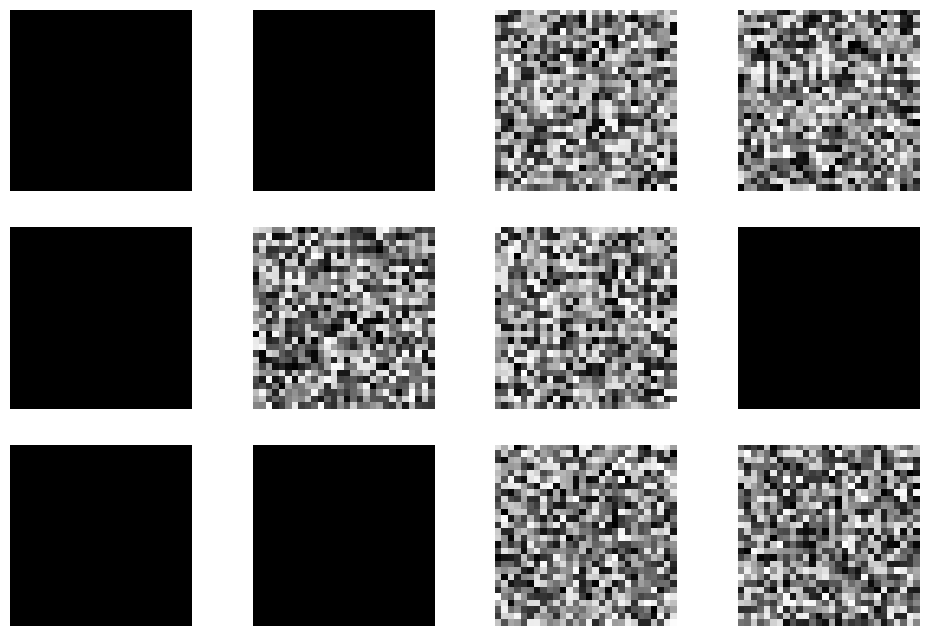

In [45]:
# visualize the images

# get some sample data
train_loader, devset_loader, testdataset = makeTheDataset(12, True)

# pop out the data matrices
img = train_loader.dataset.tensors[0].detach()

# show the numbers
fig, ax = plt.subplots(3, 4, figsize = (12, 8))
for i, ax in enumerate(ax.flatten()):
    ax.imshow(np.reshape(img[i, :], (28, 28)), cmap = "gray")
    ax.axis("off")
plt.show()

In [46]:
# creating a class for the model
def createTheMNISTNet():
    class mnistNet(nn.Module):
        def __init__(self):
            super().__init__()

            # input layer
            self.input = nn.Linear(784, 64)

            # hidden layer
            self.fc1 = nn.Linear(64, 32)
            self.fc2 = nn.Linear(32, 32)

            # output layer
            self.output = nn.Linear(32, 10)

        # forward pass
        def forward(self, x):
            x = F.relu(self.input(x))
            x = F.relu(self.fc1(x))
            x = F.relu(self.fc2(x))
            return self.output(x)

    # create the model instance
    net = mnistNet()

    # loss function
    lossfun = nn.CrossEntropyLoss()

    # optimizer
    optimizer = torch.optim.SGD(net.parameters(), lr = .01) # Adam performs way too good for this model therefore we used SGD

    return net, lossfun, optimizer

In [49]:
 # train the model

def trainTheModel():

    # training parameter
    numepochs = 50
    
    # create a new model
    net, lossfun, optimizer = createTheMNISTNet()
    
    trainAcc = []
    devsetAcc = []
    losses = torch.zeros(numepochs)
    
    # train the model
    for epochi in range(numepochs):
        
        # loop over training data batches
        batchAcc = []
        batchLoss = []
        for X, y in train_loader:

            # forward pass and loss
            yHat = net(X)
            loss = lossfun(yHat, y)
            
            # backprop
            optimizer.zero_grad()
            loss.backward()
            optimizer.step()

            # loss from this batch
            batchLoss.append(loss.item())

            # compute training accuracy for this batch
            matches = torch.argmax(yHat, axis = 1) == y # booleans (false/true); selects the class with the highest predicted probability for each input.
            # The == operator compares the predicted class to the actual class, returning a Boolean tensor (True for correct predictions, False for incorrect).
            matchesNumeric = matches.float() # convert to numbers (0/1)
            accuracyPct = 100*torch.mean(matchesNumeric) # avg and * by 100
            batchAcc.append(accuracyPct)
            
        # now that we've trained through the batches, get avg training accuracy
        trainAcc.append(np.mean(batchAcc))

        # get avg losses over the batches
        losses[epochi] = np.mean(batchLoss)

        # test accuracy
        X, y = next(iter(devset_loader))  # extract X, y from test dataloader
        with torch.no_grad():
            yHat = net(X)

        # compute test accuracy
        devsetAcc.append(100 * torch.mean((torch.argmax(yHat, axis = 1) == y).float()))
        
    # function output
    return trainAcc, devsetAcc, losses, net

In [50]:
# list of data sample sizes
samplesizes = np.arange(500, 4001,500)

# initialize results matrix
resultsSingle = np.zeros((len(samplesizes), 3))
resultsDouble = np.zeros((len(samplesizes), 3))

for idx, ssize in enumerate(samplesizes):

    # without doubling the data

    # generate a dataset and train the model
    train_loader, devset_loader, testdataset = makeTheDataset(ssize, False)
    trainAcc, devsetAcc, losses, net = trainTheModel()

    # grab the results
    resultsSingle[idx, 0] = np.mean(trainAcc[-5:])
    resultsSingle[idx, 1] = np.mean(devsetAcc[-5:])
    resultsSingle[idx, 2] = torch.mean(losses[-5:]).item()

    # with doubling the data
    
    # generate a dataset and train the model
    train_loader, devset_loader, testdataset = makeTheDataset(ssize, True)
    trainAcc, devsetAcc, losses, net = trainTheModel()

    # grab the results
    resultsDouble[idx, 0] = np.mean(trainAcc[-5:])
    resultsDouble[idx, 1] = np.mean(devsetAcc[-5:])
    resultsDouble[idx, 2] = torch.mean(losses[-5:]).item()

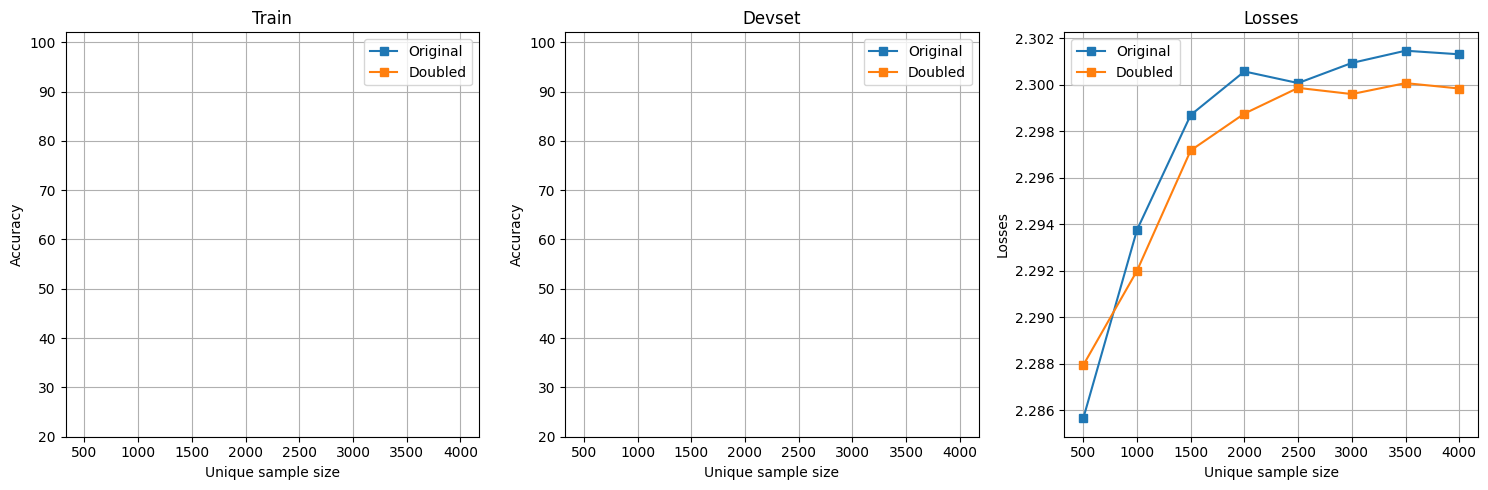

In [51]:
# plot the results
fig, ax = plt.subplots(1, 3, figsize = (15, 5))

# axis and title labels
titles = ["Train", "Devset", "Losses"]
yaxlabels = ["Accuracy", "Accuracy", "Losses"]

for i in range(3):

    # plot the lines
    ax[i].plot(samplesizes, resultsSingle[:, i], "s-", label = "Original")
    ax[i].plot(samplesizes, resultsDouble[:, i], "s-", label = "Doubled")

    # make it look nicer
    ax[i].set_ylabel(yaxlabels[i])
    ax[i].set_title(titles[i])
    ax[i].legend()
    ax[i].set_xlabel("Unique sample size")
    ax[i].grid("On")

    if i < 2:
        ax[i].set_ylim([20, 102])

plt.tight_layout()
plt.show()

In [53]:
# we need to re run the models for N = 500 for test accuracy

samplesize = 500
train_loader, devset_loader, testdataset = makeTheDataset(samplesize, False)
trainAccO, devsetAccO, lossesO, netO = trainTheModel() # O = original

train_loader, devset_loader, testdataset = makeTheDataset(samplesize, True)
trainAccA, devsetAccA, lossesA, netA = trainTheModel() # A = augmented

In [54]:
# Now for the real test on test data

# extract the test data
X, y = testdataset

# run the original model
yHat = netO(X)
testO = 100*torch.mean((torch.argmax(yHat, axis = 1) == y).float())

# and the augmented model
yHat = netA(X)
testA = 100*torch.mean((torch.argmax(yHat, axis = 1) == y).float())

# print the results
print(f'Original Model (N={samplesize}):\n  Train: {trainAccO[-1]:.2f}%, devset: {devsetAccO[-1]:.2f}%, test: {testO:.2f}%\n\n')
print(f'Augmented Model (N={samplesize}):\n  Train: {trainAccA[-1]:.2f}%, devset: {devsetAccA[-1]:.2f}%, test: {testA:.2f}%')

Original Model (N=500):
  Train: 12.95%, devset: 12.00%, test: 9.87%


Augmented Model (N=500):
  Train: 12.78%, devset: 15.00%, test: 9.87%
